In [20]:
from src import data

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

### Load in Train and Validation Datasets

In [7]:
# Buouy data paths for wave related measurements
DATA_PATH_2022 = 'data/targetstation46240/46240h2022.txt'
DATA_PATH_2021 = 'data/targetstation46240/46240h2021.txt'
DATA_PATH_2020 = 'data/targetstation46240/46240h2020.txt'
DATA_PATH_2019 = 'data/targetstation46240/46240h2019.txt'
DATA_PATH_2018 = 'data/targetstation46240/46240h2018.txt'
DATA_PATH_2017 = 'data/targetstation46240/46240h2017.txt'
DATA_PATH_2016 = 'data/targetstation46240/46240h2016.txt'
DATA_PATH_2015 = 'data/targetstation46240/46240h2015.txt'
DATA_PATH_2014 = 'data/targetstation46240/46240h2014.txt'
DATA_PATH_2013 = 'data/targetstation46240/46240h2013.txt'
DATA_PATH_2012 = 'data/targetstation46240/46240h2012.txt'
DATA_PATH_2011 = 'data/targetstation46240/46240h2011.txt'
DATA_PATH_2010 = 'data/targetstation46240/46240h2010.txt'
DATA_PATH_2009 = 'data/targetstation46240/46240h2009.txt'

feature_set = ['WVHT', 'DPD', 'APD', 'MWD', 'WTMP']

file_paths = [DATA_PATH_2009,DATA_PATH_2010, DATA_PATH_2011, DATA_PATH_2012, DATA_PATH_2013, 
              DATA_PATH_2014, DATA_PATH_2015, DATA_PATH_2016, DATA_PATH_2017, DATA_PATH_2018, 
              DATA_PATH_2019, DATA_PATH_2020, DATA_PATH_2021, DATA_PATH_2022]

In [8]:
# Re-reading and combining data from all files with outliers replaced by NaN
all_wave_data = pd.concat([data.process_file_to_hourly_last(file) for file in file_paths])

all_wave_data.drop(columns=['WDIR', 'WSPD', 'GST', 'PRES', 'DEWP', 'VIS', 'TIDE', 'ATMP'], inplace=True)

In [9]:
# drop rows that contain NaN values
all_wave_data.dropna(inplace=True)

In [10]:
all_wave_data

,Year,Month,Day,Hour,WVHT,DPD,APD,MWD,WTMP
datetime,,,,,,,,,
2009-01-01 00:00:00,2009,1,1,0,1.12,11.76,7.91,352.0,11.9
2009-01-01 01:00:00,2009,1,1,1,1.02,10.53,6.31,346.0,11.9
2009-01-01 02:00:00,2009,1,1,2,1.07,11.11,5.61,352.0,11.9
2009-01-01 03:00:00,2009,1,1,3,1.14,11.76,5.42,352.0,11.9
2009-01-01 04:00:00,2009,1,1,4,1.00,13.33,5.65,359.0,11.9
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,2022,12,31,19,1.19,10.53,9.75,341.0,13.3
2022-12-31 20:00:00,2022,12,31,20,1.37,11.11,10.35,345.0,13.3
2022-12-31 21:00:00,2022,12,31,21,1.21,11.76,9.90,348.0,13.3


### Feature Distributions

#### Feature Histogram Plots

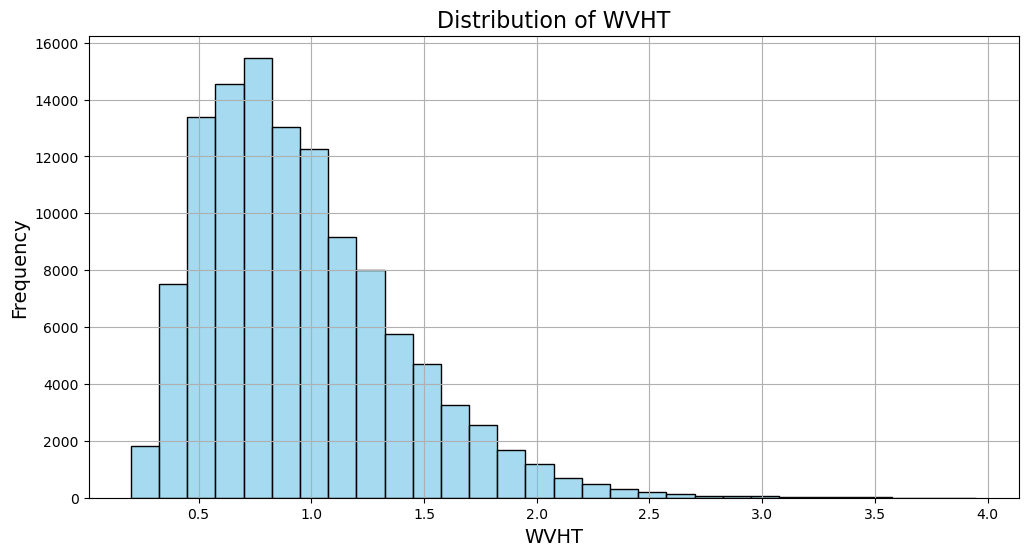

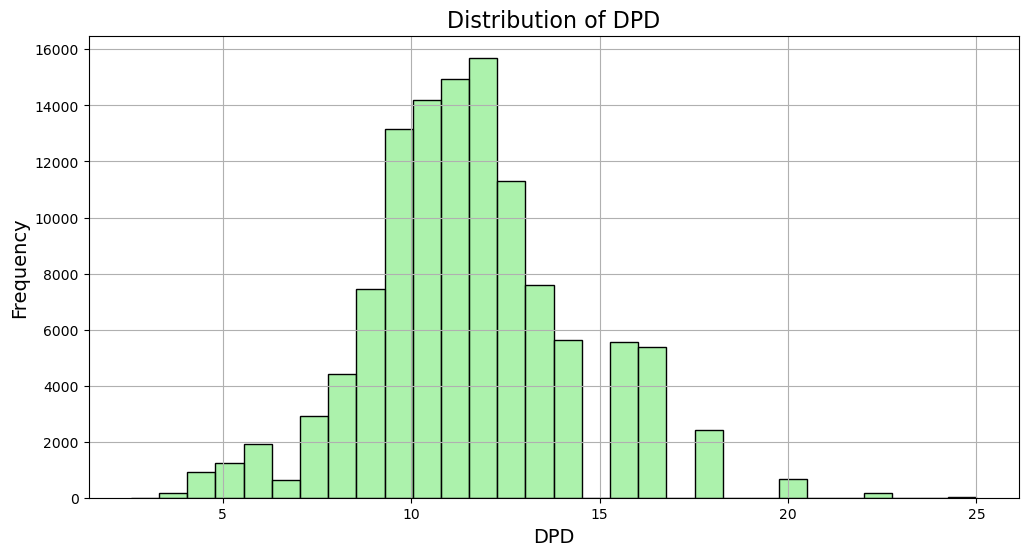

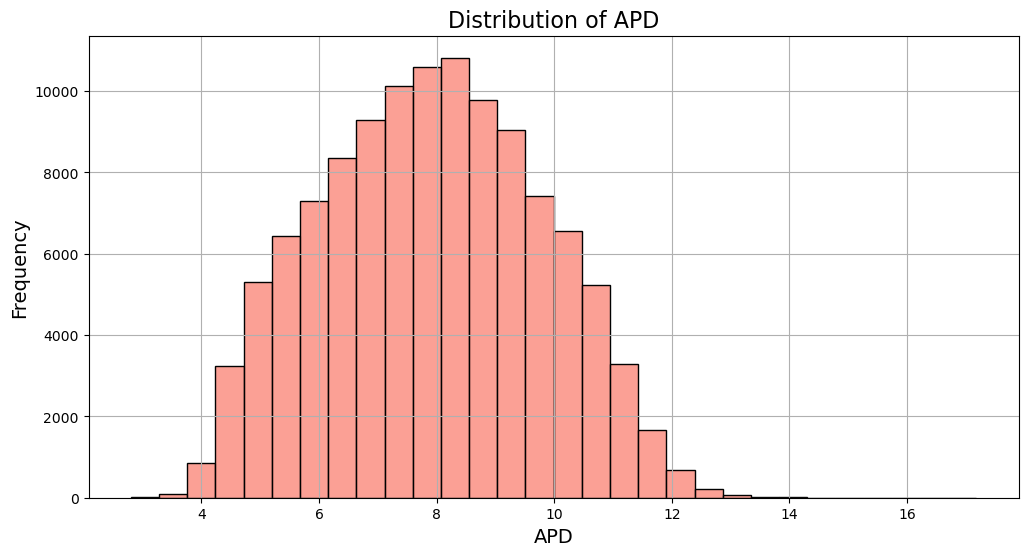

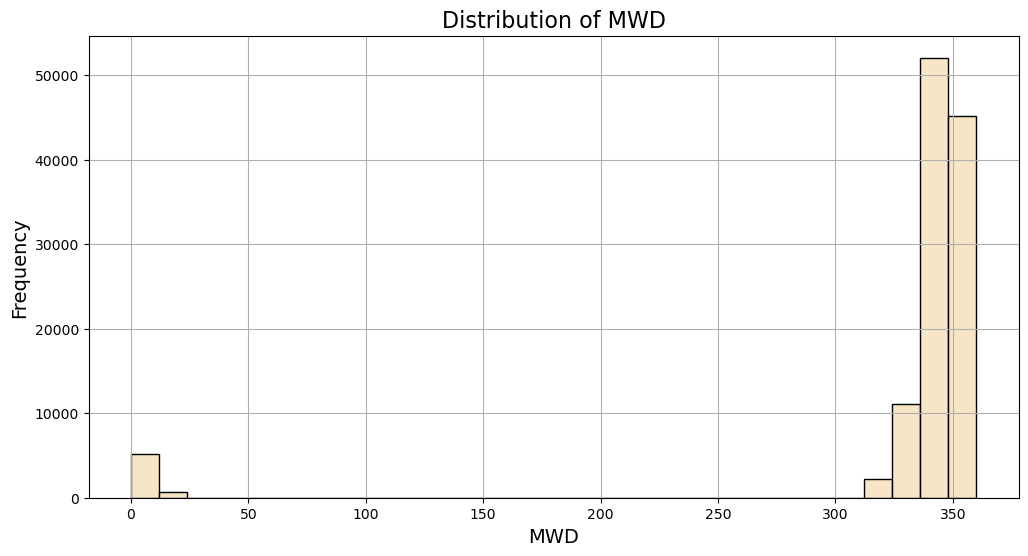

In [23]:
features = ['WVHT', 'DPD', 'APD', 'MWD']

feature_colors = {
    'WVHT': 'skyblue',
    'DPD': 'lightgreen',
    'APD': 'salmon',
    'MWD': 'wheat',
    'WTMP': 'lightcoral'
}

for feature in features:
    plt.figure(figsize=(12, 6))
    sns.histplot(all_wave_data[feature], bins=30, kde=False, color=feature_colors[feature], edgecolor='black')
    
    plt.title(f'Distribution of {feature}', fontsize=16)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True)
    # Set axis limits if needed
    # plt.xlim([lower_bound, upper_bound])
    
    plt.show()

#### Feature Temporal Distributions

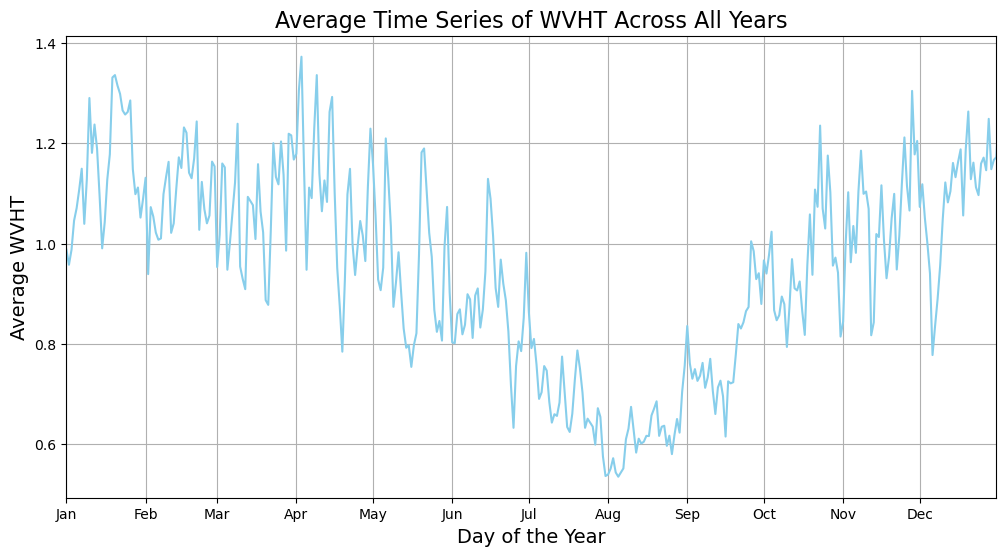

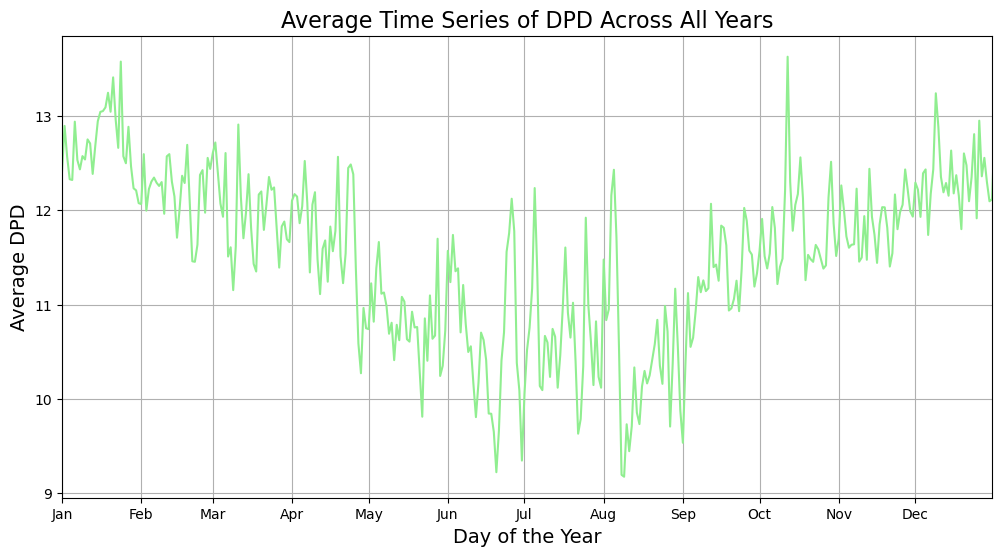

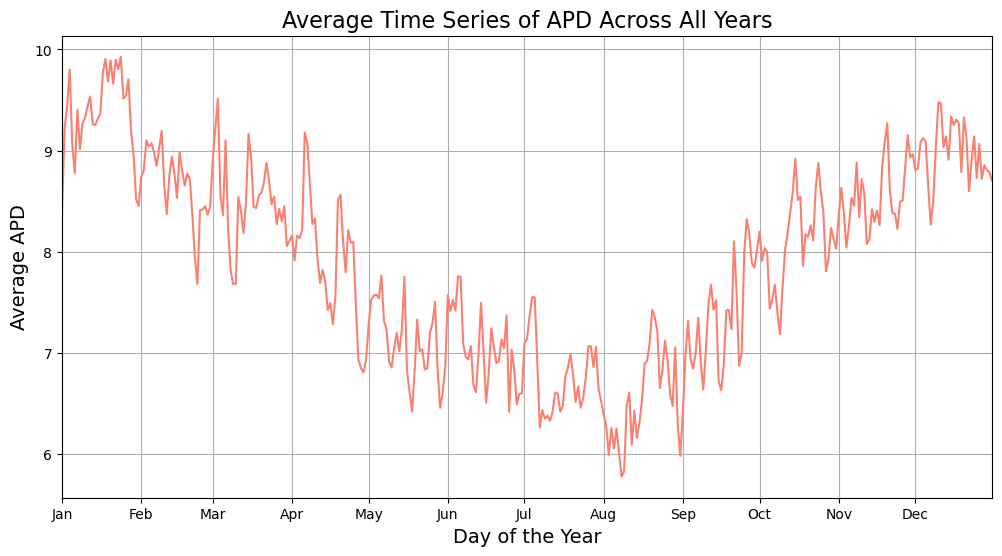

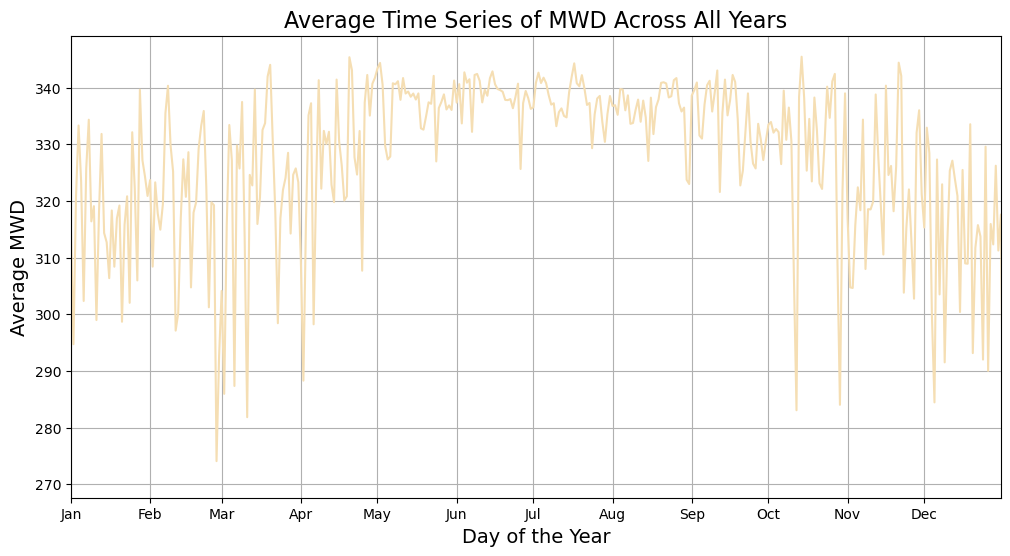

In [25]:
# Plot the average feature value for each day of the year
all_wave_data.index = pd.to_datetime(all_wave_data.index)

all_wave_data['dayofyear'] = all_wave_data.index.dayofyear

daily_means = all_wave_data.groupby('dayofyear').mean()

for feature in features:
    plt.figure(figsize=(12, 6))
    
    # Plot the average feature value for each day of the year
    plt.plot(daily_means.index, daily_means[feature], color=feature_colors[feature])
    
    plt.title(f'Average Time Series of {feature} Across All Years', fontsize=16)
    plt.xlabel('Day of the Year', fontsize=14)
    plt.ylabel('Average ' + feature, fontsize=14)
   
    plt.grid(True)
    
    # Set x-axis limits to the day of the year (e.g., 1-365)
    plt.xlim(1, 365)
    
    # Set the x-axis ticks to be the start of each month
    plt.xticks((1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335),
               ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
    
    plt.show()

#### Assessing Wave Height Outlier Years

In [28]:
# Sums deviation from daily wave height for each day of each year to determine which years are outliers
daily_avg_all_years = all_wave_data['WVHT'].groupby(all_wave_data.index.dayofyear).mean()

all_wave_data['year'] = all_wave_data.index.year

daily_avg_by_year = all_wave_data['WVHT'].groupby([all_wave_data['year'], all_wave_data.index.dayofyear]).mean().unstack(level=0)

deviations = daily_avg_by_year.subtract(daily_avg_all_years, axis=0).fillna(0)

uniqueness_score = deviations.abs().sum()

ranked_years = uniqueness_score.sort_values(ascending=False)

ranked_years

year
2016    110.302187
2013    106.006169
2009    102.824910
2010    101.288997
2017     99.855620
2015     98.901758
2012     95.922856
2019     95.885272
2018     95.168849
2022     90.638170
2011     90.576918
2020     86.525737
2021     85.810903
2014     65.602134
dtype: float64

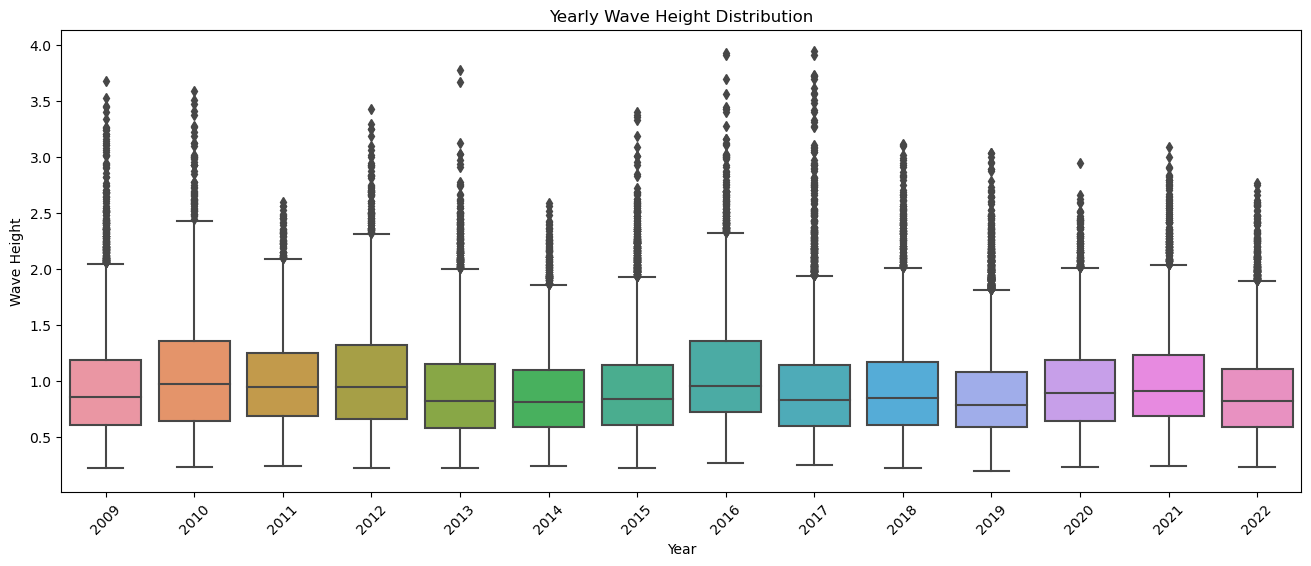

In [30]:
all_wave_data['year'] = all_wave_data.index.year

plt.figure(figsize=(16, 6))
sns.boxplot(x='year', y='WVHT', data=all_wave_data)
plt.title('Yearly Wave Height Distribution')
plt.xlabel('Year')
plt.ylabel('Wave Height')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()